In [0]:
import pyspark
print(pyspark.__version__)

3.1.2

In [0]:
import sys

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import max as max_

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
from matplotlib import pyplot as plt
import regex
from collections import Counter
from prophet import Prophet


In [0]:
import math
import numpy as np
from pyspark.ml.feature import Tokenizer
import nltk
nltk.download('punkt')
from nltk.stem.porter import *
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from sklearn.metrics import mean_absolute_error
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Package punkt is already up-to-date!

## Data Pre-Processing

In [0]:
database = 'Project'
collection = 'sub_comments_spx_aggregate_new_all'
user_name = 'msds697_admin'
password = 'msds697rocks'
address = 'msds697-cluster.f5ljp.mongodb.net'
connection_string = f"mongodb+srv://{user_name}:{password}@{address}/{database}.{collection}"

In [0]:
# Read data from mongodb atlas database
df = spark.read.format("mongo").option("uri",connection_string).load().cache()
df.show()

+--------------------+--------------------+-----------+--------------------+---------+--------------------+
 _id| comments|created_utc| self_text|spx_index| title_list|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+
{6409ac8d88e3a86a...|[I pray you are r...| 2017-01-01|[, How do I short...| null|[I, too, posted s...|
{6409ac8d88e3a86a...|[rekt, lol what a...| 2017-01-02|[[removed], , [re...| null|[What caused Nort...|
{6409ac8d88e3a86a...|[Because the vich...| 2017-01-03|[, [deleted], I'm...| 2257.83|[Should I sell $D...|
{6409ac8d88e3a86a...|[It's a pain to w...| 2017-01-04|[So I have 20, 9 ...| 2270.75|[XRX options, pls...|
{6409ac8d88e3a86a...|[Buy EAT or NSP b...| 2017-01-05|[, [removed], All...| 2269.0|[$HRTX HTX-011 De...|
{6409ac8d88e3a86a...|[I think that sta...| 2017-01-06|[Hi
I'm new here....| 2276.98|[New to r/wallstr...|
{6409ac8d88e3a86a...|[Ah thanks!! You'...| 2017-01-07|[I bought some ma...| null|[$PANW....Going t...|
{6409ac8d88e3a86a...|[That's insane. I...| 2017-01-08|[, , LULU will be...| null|[Throwback for ne...|
{6409ac8d88e3a86a...|[Ichan owning FNM...| 2017-01-09|[, View full info...| 2268.9|[I think it's tim...|
{6409ac8d88e3a86a...|[The strength in ...| 2017-01-10|[Here are the hig...| 2268.9|[High Momentum Sm...|
{6409ac8d88e3a86a...|[Held UWTI in my ...| 2017-01-11|[, [removed], Any...| 2275.32|[Apparently insid...|
{6409ac8d88e3a86a...|[Down 8% after ho...| 2017-01-12|[How do I monitor...| 2270.44|[TWS performance ...|
{6409ac8d88e3a86a...|[What are the odd...| 2017-01-13|[[removed], HPQ i...| 2274.64|[Will FB &amp; CC...|
{6409ac8d88e3a86a...|[100k on margin b...| 2017-01-14|[[removed], [dele...| null|[Palatin Technolo...|
{6409ac8d88e3a86a...|[This is the pump...| 2017-01-15|[Let's say I buy ...| null|[Will this ETF st...|
{6409ac8d88e3a86a...|[The Google pixel...| 2017-01-16|[, A few weeks ag...| null|[Using Scale Trad...|
{6409ac8d88e3a86a...|[PUMP PUMP PUMP!!...| 2017-01-17|[It's about that ...| 2267.89|[Strong Chinese S...|
{6409ac8d88e3a86a...|[Cutting loss is ...| 2017-01-18|[[deleted], I thi...| 2271.89|[Verizon has alre...|
{6409ac8d88e3a86a...|[I’m so glad am i...| 2017-01-19|[Need to make mon...| 2263.69|[Which stocks doe...|
{6409ac8d88e3a86a...|[Open an online d...| 2017-01-20|[[removed], , Buy...| 2271.31|[What the actual ...|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+
only showing top 20 rows

In [0]:
# There are 2002 data points in this dataset (5.5 years)
df.count()

Out[6]: 2001

In [0]:
# Add "date" column to convert "create_utc" column into date type
df2 = df.withColumn('date', to_date(col('created_utc')))
df2.show()

+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+
 _id| comments|created_utc| self_text|spx_index| title_list| date|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+
{6409ac8d88e3a86a...|[I pray you are r...| 2017-01-01|[, How do I short...| null|[I, too, posted s...|2017-01-01|
{6409ac8d88e3a86a...|[rekt, lol what a...| 2017-01-02|[[removed], , [re...| null|[What caused Nort...|2017-01-02|
{6409ac8d88e3a86a...|[Because the vich...| 2017-01-03|[, [deleted], I'm...| 2257.83|[Should I sell $D...|2017-01-03|
{6409ac8d88e3a86a...|[It's a pain to w...| 2017-01-04|[So I have 20, 9 ...| 2270.75|[XRX options, pls...|2017-01-04|
{6409ac8d88e3a86a...|[Buy EAT or NSP b...| 2017-01-05|[, [removed], All...| 2269.0|[$HRTX HTX-011 De...|2017-01-05|
{6409ac8d88e3a86a...|[I think that sta...| 2017-01-06|[Hi
I'm new here....| 2276.98|[New to r/wallstr...|2017-01-06|
{6409ac8d88e3a86a...|[Ah thanks!! You'...| 2017-01-07|[I bought some ma...| null|[$PANW....Going t...|2017-01-07|
{6409ac8d88e3a86a...|[That's insane. I...| 2017-01-08|[, , LULU will be...| null|[Throwback for ne...|2017-01-08|
{6409ac8d88e3a86a...|[Ichan owning FNM...| 2017-01-09|[, View full info...| 2268.9|[I think it's tim...|2017-01-09|
{6409ac8d88e3a86a...|[The strength in ...| 2017-01-10|[Here are the hig...| 2268.9|[High Momentum Sm...|2017-01-10|
{6409ac8d88e3a86a...|[Held UWTI in my ...| 2017-01-11|[, [removed], Any...| 2275.32|[Apparently insid...|2017-01-11|
{6409ac8d88e3a86a...|[Down 8% after ho...| 2017-01-12|[How do I monitor...| 2270.44|[TWS performance ...|2017-01-12|
{6409ac8d88e3a86a...|[What are the odd...| 2017-01-13|[[removed], HPQ i...| 2274.64|[Will FB &amp; CC...|2017-01-13|
{6409ac8d88e3a86a...|[100k on margin b...| 2017-01-14|[[removed], [dele...| null|[Palatin Technolo...|2017-01-14|
{6409ac8d88e3a86a...|[This is the pump...| 2017-01-15|[Let's say I buy ...| null|[Will this ETF st...|2017-01-15|
{6409ac8d88e3a86a...|[The Google pixel...| 2017-01-16|[, A few weeks ag...| null|[Using Scale Trad...|2017-01-16|
{6409ac8d88e3a86a...|[PUMP PUMP PUMP!!...| 2017-01-17|[It's about that ...| 2267.89|[Strong Chinese S...|2017-01-17|
{6409ac8d88e3a86a...|[Cutting loss is ...| 2017-01-18|[[deleted], I thi...| 2271.89|[Verizon has alre...|2017-01-18|
{6409ac8d88e3a86a...|[I’m so glad am i...| 2017-01-19|[Need to make mon...| 2263.69|[Which stocks doe...|2017-01-19|
{6409ac8d88e3a86a...|[Open an online d...| 2017-01-20|[[removed], , Buy...| 2271.31|[What the actual ...|2017-01-20|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+
only showing top 20 rows

In [0]:
# Start date and end date
df2.agg(min(col('date'))).show()
df2.agg(max(col('date'))).show()

+----------+
 min(date)|
+----------+
2017-01-01|
+----------+

+----------+
 max(date)|
+----------+
2022-06-30|
+----------+

In [0]:
def clean_text(x):
    return_list = []
    for text in x:
        if (text == '[removed]') or (text == '[deleted]'):
            return_list.append('')
        else:
            text = text.replace("[^a-zA-Z]",' ')
            text = text.lower()
            words = text.split()
            words = [i for i in words if 'http' not in i]
            words = ' '.join(words)
            return_list.append(words)
    return_string = ' '.join(return_list)
    return return_string

In [0]:
# Create a udf to return the length of text
get_len_udf = udf(lambda x:len(x), IntegerType())
# Create a udf to clean text
clean_text_udf = udf(clean_text)

In [0]:
# Create udf to map stock index to 1 (up) if positive or 0 (down) if negative
up_down_udf = udf(lambda x:1 if x is not None and x>=0 else 0, IntegerType())

In [0]:
# Add "next day" column which holds the index of the next day
df3 = df2.withColumn('next_day', lead(col('spx_index')).over(Window.orderBy(col('date'))))
# Add "diff" column which holds the difference between current day and next day's indices
df3 = df3.withColumn('diff', col('next_day')-col('spx_index'))
# Fill missing values with the behind non-null value(backward)
df3 = df3.withColumn('fill_diff', first(col('diff'), ignorenulls=True).over(Window.orderBy('date').rowsBetween(0, sys.maxsize)))
# Add "y" column which is the target variable; 1 means stock price went up, 0 means down
df3 = df3.withColumn('y', up_down_udf(col('fill_diff')))
# Add columns which hold processed post body text, comments, and title list
df3 = df3.withColumn('clean_text', clean_text_udf(col('self_text')))\
    .withColumn('clean_comments', clean_text_udf(col('comments')))\
    .withColumn('clean_title', clean_text_udf(col('title_list')))
# Add "len_clean_text" column which holds the length of each post
df3 = df3.withColumn('len_clean_text', get_len_udf(col('clean_text')))
# Add "merged_comm_title_st" column which is the combination of post body text, comments and title list,
# and only show 4 columns
df3 = df3.withColumn('merged_comm_title_st', concat(df3.clean_comments, df3.clean_text, df3.clean_title))\
    .select(col('date'), col('spx_index'), col('merged_comm_title_st'), col('y'),col('fill_diff'))
# Add "len_merged" column which holds the length of the combined texts, comments, and title lists
df3 = df3.withColumn('len_merged', get_len_udf(col('merged_comm_title_st')))
df3 = df3.cache()
df3.show()

+----------+---------+--------------------+---+------------------+----------+
 date|spx_index|merged_comm_title_st| y| fill_diff|len_merged|
+----------+---------+--------------------+---+------------------+----------+
2017-01-01| null|i pray you are ri...| 1|12.920000000000073| 23899|
2017-01-02| null|rekt lol what a s...| 1|12.920000000000073| 32629|
2017-01-03| 2257.83|because the viche...| 1|12.920000000000073| 48236|
2017-01-04| 2270.75|it's a pain to wa...| 0| -1.75| 83417|
2017-01-05| 2269.0|buy eat or nsp bo...| 1| 7.980000000000018| 88817|
2017-01-06| 2276.98|i think that stat...| 1| 0.0| 87704|
2017-01-07| null|ah thanks!! you'r...| 1| 0.0| 37990|
2017-01-08| null|that's insane. if...| 1| 0.0| 45823|
2017-01-09| 2268.9|ichan owning fnma...| 1| 0.0| 92675|
2017-01-10| 2268.9|the strength in g...| 1| 6.420000000000073| 94397|
2017-01-11| 2275.32|held uwti in my 4...| 0|-4.880000000000109| 91550|
2017-01-12| 2270.44|down 8% after hou...| 1| 4.199999999999818| 109620|
2017-01-13| 2274.64|what are the odds...| 1| 4.0| 96280|
2017-01-14| null|100k on margin be...| 1| 4.0| 27524|
2017-01-15| null|this is the pump ...| 1| 4.0| 44116|
2017-01-16| null|the google pixel ...| 1| 4.0| 75962|
2017-01-17| 2267.89|pump pump pump!! ...| 1| 4.0| 112756|
2017-01-18| 2271.89|cutting loss is t...| 0|-8.199999999999818| 94051|
2017-01-19| 2263.69|i’m so glad am in...| 1| 7.619999999999891| 119052|
2017-01-20| 2271.31|open an online da...| 1|14.870000000000346| 56398|
+----------+---------+--------------------+---+------------------+----------+
only showing top 20 rows

Out[13]:

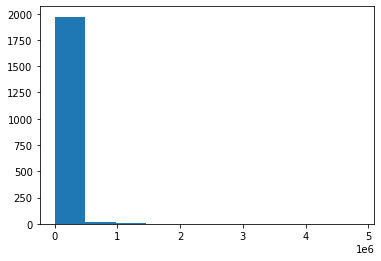

(array([1.971e+03, 2.000e+01, 3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([4.1350000e+03, 4.8923290e+05, 9.7433080e+05, 1.4594287e+06,
 1.9445266e+06, 2.4296245e+06, 2.9147224e+06, 3.3998203e+06,
 3.8849182e+06, 4.3700161e+06, 4.8551140e+06]),
 <BarContainer object of 10 artists>)

In [0]:
# Visualize the distribution of text lengths
len_list = df3.select('len_merged').rdd.flatMap(lambda x:x).collect()
plt.hist(len_list)

Out[14]:

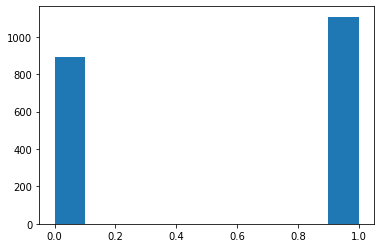

(array([ 894., 0., 0., 0., 0., 0., 0., 0., 0.,
 1107.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

In [0]:
label_list = df3.select('y').rdd.flatMap(lambda x:x).collect()
plt.hist(label_list)

In [0]:
# Train, test split (5 years for train, 6 months for test)
trainDF = df3.filter('date<="2022-01-01"')
testDF = df3.filter('date>"2022-01-01"')

In [0]:
trainDF.show()

+----------+---------+--------------------+---+------------------+----------+
 date|spx_index|merged_comm_title_st| y| fill_diff|len_merged|
+----------+---------+--------------------+---+------------------+----------+
2017-01-01| null|i pray you are ri...| 1|12.920000000000073| 23899|
2017-01-02| null|rekt lol what a s...| 1|12.920000000000073| 32629|
2017-01-03| 2257.83|because the viche...| 1|12.920000000000073| 48236|
2017-01-04| 2270.75|it's a pain to wa...| 0| -1.75| 83417|
2017-01-05| 2269.0|buy eat or nsp bo...| 1| 7.980000000000018| 88817|
2017-01-06| 2276.98|i think that stat...| 1| 0.0| 87704|
2017-01-07| null|ah thanks!! you'r...| 1| 0.0| 37990|
2017-01-08| null|that's insane. if...| 1| 0.0| 45823|
2017-01-09| 2268.9|ichan owning fnma...| 1| 0.0| 92675|
2017-01-10| 2268.9|the strength in g...| 1| 6.420000000000073| 94397|
2017-01-11| 2275.32|held uwti in my 4...| 0|-4.880000000000109| 91550|
2017-01-12| 2270.44|down 8% after hou...| 1| 4.199999999999818| 109620|
2017-01-13| 2274.64|what are the odds...| 1| 4.0| 96280|
2017-01-14| null|100k on margin be...| 1| 4.0| 27524|
2017-01-15| null|this is the pump ...| 1| 4.0| 44116|
2017-01-16| null|the google pixel ...| 1| 4.0| 75962|
2017-01-17| 2267.89|pump pump pump!! ...| 1| 4.0| 112756|
2017-01-18| 2271.89|cutting loss is t...| 0|-8.199999999999818| 94051|
2017-01-19| 2263.69|i’m so glad am in...| 1| 7.619999999999891| 119052|
2017-01-20| 2271.31|open an online da...| 1|14.870000000000346| 56398|
+----------+---------+--------------------+---+------------------+----------+
only showing top 20 rows

In [0]:
print(trainDF.count(), testDF.count())

1821 180

# Build a baseline bag-of-words model

### Vectorize textual data

In [0]:
# Tokenize texts
tokenizer = Tokenizer(inputCol = 'merged_comm_title_st', outputCol = 'words')
wordsData = tokenizer.transform(trainDF)
# Remove English stop words
nostopwordsUDF = udf(lambda x:[w for w in x if w not in ENGLISH_STOP_WORDS],
                     ArrayType(StringType(), False))
nostopwordsData = wordsData.withColumn('no_stop_words',
                                       nostopwordsUDF(col('words')))
# Stem the remaining words (reduce them to their root form)
stemUDF = udf(lambda x:[PorterStemmer().stem(w) for w in x],
              ArrayType(StringType(), False))
stemmedwordsData = nostopwordsData.withColumn('stem_words',
                                              stemUDF(col('no_stop_words')))
wordstestData = tokenizer.transform(testDF)
nostopwordstestData = wordstestData.withColumn('no_stop_words',
                                               nostopwordsUDF(col('words')))
stemmedwordstestData = nostopwordstestData.withColumn('stem_words',
                                                      stemUDF(col('no_stop_words')))
# Create a feature vector (a mathematical representation of the text data)
count = CountVectorizer(inputCol='no_stop_words',
                        outputCol='rawFeatures')
# Fit the count vectorizer to the training set
model = count.fit(nostopwordsData)
# Apply the trained model to both the training and test sets to create feature vectors for each set
featurizedData = model.transform(nostopwordsData)
featurizedtestData = model.transform(nostopwordstestData)
# Display the resulting featurized data for the training set
featurizedData.show()

+----------+---------+--------------------+---+------------------+----------+--------------------+--------------------+--------------------+
 date|spx_index|merged_comm_title_st| y| fill_diff|len_merged| words| no_stop_words| rawFeatures|
+----------+---------+--------------------+---+------------------+----------+--------------------+--------------------+--------------------+
2017-01-01| null|i pray you are ri...| 1|12.920000000000073| 23899|[i, pray, you, ar...|[pray, right..., ...|(262144,[0,1,2,3,...|
2017-01-02| null|rekt lol what a s...| 1|12.920000000000073| 32629|[rekt, lol, what,...|[rekt, lol, shit,...|(262144,[0,1,2,3,...|
2017-01-03| 2257.83|because the viche...| 1|12.920000000000073| 48236|[because, the, vi...|[viche, french, s...|(262144,[0,1,2,3,...|
2017-01-04| 2270.75|it's a pain to wa...| 0| -1.75| 83417|[it's, a, pain, t...|[it's, pain, watc...|(262144,[0,1,2,3,...|
2017-01-05| 2269.0|buy eat or nsp bo...| 1| 7.980000000000018| 88817|[buy, eat, or, ns...|[buy, eat, nsp, c...|(262144,[0,1,2,3,...|
2017-01-06| 2276.98|i think that stat...| 1| 0.0| 87704|[i, think, that, ...|[think, statement...|(262144,[0,1,2,3,...|
2017-01-07| null|ah thanks!! you'r...| 1| 0.0| 37990|[ah, thanks!!, yo...|[ah, thanks!!, yo...|(262144,[0,1,2,3,...|
2017-01-08| null|that's insane. if...| 1| 0.0| 45823|[that's, insane.,...|[that's, insane.,...|(262144,[0,1,2,3,...|
2017-01-09| 2268.9|ichan owning fnma...| 1| 0.0| 92675|[ichan, owning, f...|[ichan, owning, f...|(262144,[0,1,2,3,...|
2017-01-10| 2268.9|the strength in g...| 1| 6.420000000000073| 94397|[the, strength, i...|[strength, gold, ...|(262144,[0,1,2,3,...|
2017-01-11| 2275.32|held uwti in my 4...| 0|-4.880000000000109| 91550|[held, uwti, in, ...|[held, uwti, 401k...|(262144,[0,1,2,3,...|
2017-01-12| 2270.44|down 8% after hou...| 1| 4.199999999999818| 109620|[down, 8%, after,...|[8%, hours., i've...|(262144,[0,1,2,3,...|
2017-01-13| 2274.64|what are the odds...| 1| 4.0| 96280|[what, are, the, ...|[odds, winning, 1...|(262144,[0,1,2,3,...|
2017-01-14| null|100k on margin be...| 1| 4.0| 27524|[100k, on, margin...|[100k, margin, ri...|(262144,[0,1,2,3,...|
2017-01-15| null|this is the pump ...| 1| 4.0| 44116|[this, is, the, p...|[pump, dump, guy,...|(262144,[0,1,2,3,...|
2017-01-16| null|the google pixel ...| 1| 4.0| 75962|[the, google, pix...|[google, pixel, j...|(262144,[0,1,2,3,...|
2017-01-17| 2267.89|pump pump pump!! ...| 1| 4.0| 112756|[pump, pump, pump...|[pump, pump, pump...|(262144,[0,1,2,3,...|
2017-01-18| 2271.89|cutting loss is t...| 0|-8.199999999999818| 94051|[cutting, loss, i...|[cutting, loss, t...|(262144,[0,1,2,3,...|
2017-01-19| 2263.69|i’m so glad am in...| 1| 7.619999999999891| 119052|[i’m, so, glad, a...|[i’m, glad, inves...|(262144,[0,1,2,3,...|
2017-01-20| 2271.31|open an online da...| 1|14.870000000000346| 56398|[open, an, online...|[open, online, da...|(262144,[0,1,2,3,...|
+----------+---------+--------------------+---+------------------+----------+--------------------+--------------------+--------------------+
only showing top 20 rows

### Improve the quality of feature vectors using TF-IDF

In [0]:
# Calculate the inverse document frequency (IDF) of the feature vectors
idf = IDF(inputCol='rawFeatures',outputCol='features')
# Fit an IDF model to the feature vectors of the training data
idfModel = idf.fit(featurizedData)
# Transform the feature vectors of both the training and test data using the IDF model
rescaledData = idfModel.transform(featurizedData)
rescaledtestData = idfModel.transform(featurizedtestData)
rescaledData.select('y','features').show()

+---+--------------------+
 y| features|
+---+--------------------+
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 0|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 0|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 0|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
 1|(262144,[0,1,2,3,...|
+---+--------------------+
only showing top 20 rows

## Data Training

In [0]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
#fin_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone', truncation=True, padding=True, max_length=512)
fin_tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=fin_tokenizer)

### Build a classification model for the textual data using the random forest algorithm

In [0]:
trainData = rescaledData.select(col('y').alias('label'),'features')
testData = rescaledtestData.select(col('y').alias('label'),'features')

In [0]:
trainData.printSchema()

root
-- label: integer (nullable = true)
-- features: vector (nullable = true)

In [0]:
# Custom Random Search Class
# Source: https://gist.github.com/SimenAlexanderLingeJohnsen/96b683cc67608d29ee1dc448818092f2
class RandomGridBuilder: 
  '''Grid builder for random search. Sets up grids for use in CrossValidator in Spark
  using values randomly sampled from user-provided distributions.
  Distributions should be provided as lambda functions, so that the numbers are generated at call time.
  
  Parameters:
    num_models: Integer (Python) - number of models to generate hyperparameters for
    seed: Integer (Python) - seed (optional, default is None)
    
  Returns:
    param_map: list of parameter maps to use in cross validation.
    
  Example usage:
    from pyspark.ml.classification import LogisticRegression
    lr = LogisticRegression()
    paramGrid = RandomGridBuilder(2)\
               .addDistr(lr.regParam, lambda: np.random.rand()) \
               .addDistr(lr.maxIter, lambda : np.random.randint(10))\
               .build()
               
    Returns similar output as Spark ML class ParamGridBuilder and can be used in its place. The above paramGrid provides random hyperparameters for 2 models.
    '''
  
  def __init__(self, num_models, seed=None):
    self._param_grid = {}
    self.num_models = num_models
    self.seed = seed
    
  def addDistr(self, param, distr_generator):
    '''Add distribution based on dictionary generated by function passed to addDistr.'''
    
    if 'pyspark.ml.param.Param' in str(type(param)):
      self._param_grid[param] = distr_generator
    else:
      raise TypeError('param must be an instance of Param')

    return self
  
  def build(self):    
    param_map = []
    for n in range(self.num_models):
      if self.seed:
        # Set seeds for both numpy and random in case either is used for the random distribution
        np.random.seed(self.seed + n)
        random.seed(self.seed + n)
      param_dict = {}
      for param, distr in self._param_grid.items():
        param_dict[param] = distr()
      param_map.append(param_dict)
    
    return param_map

In [0]:
# Initializes a random forest classifier with the label column and rescaled feature vectors as inputs.
clf = RandomForestClassifier(labelCol = 'label',
                            featuresCol = 'features')
# Set up cross validation with random grid search (15 combinations)
randomParams = RandomGridBuilder(15)\
                 .addDistr(clf.maxDepth, lambda : np.random.randint(10, 30))\
                 .addDistr(clf.numTrees, lambda : np.random.randint(10, 100))\
                 .build()
# Initialize a cross-validator to tune hyperparameters
crossval_rf = CrossValidator(estimator = clf,
                             estimatorParamMaps = randomParams,
                             evaluator = BinaryClassificationEvaluator(),
                             numFolds = 5)

# Fit the cross-validator to the training data
crossval_rf = crossval_rf.fit(trainData)
# Transform the test data using the trained cross-validator to generate predictions for the label column
predictions_rf = crossval_rf.transform(testData)
# Get the count of actual and predicted labels
predictions_rf.groupBy('label', 'prediction').count().show()
# Initialize a binary classification evaluator to evaluate the performance of the predictions using AUC-ROC
my_eval_rf = BinaryClassificationEvaluator(rawPredictionCol = 'prediction',
                                           labelCol = 'label',
                                           metricName = 'areaUnderROC')

+-----+----------+-----+
label|prediction|count|
+-----+----------+-----+
 1| 0.0| 22|
 0| 0.0| 16|
 1| 1.0| 59|
 0| 1.0| 83|
+-----+----------+-----+

In [0]:
crossval_rf.bestModel.extractParamMap()

Out[231]: {Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'auto',
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='labelCol', doc='label column name.'): 'label',
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='leafCol', doc='Leaf indices column name. Predicted leaf index of each instance in each tree by preorder.'): '',
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 23,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size.'): 256,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='minWeightFractionPerNode', doc='Minimum fraction of the weighted sample count that each child must have after split. If a split causes the fraction of the total weight in the left or right child to be less than minWeightFractionPerNode, the split will be discarded as invalid. Should be in interval [0.0, 0.5).'): 0.0,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='numTrees', doc='Number of trees to train (>= 1).'): 56,
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='RandomForestClassifier_3eb4ed05a5d9', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilitie

In [0]:
my_eval_rf.evaluate(predictions_rf)

Out[56]: 0.44500561167227837

### Ruirui Zhang
### How encourage words and discourage words correlates the price ups/downs
I want to find out if we can predict if price goes up/down the next day using the encourage buy or discourage buy related words seen on Reddit on current day. I'll build a random forest model to predict "y" using 2 predictor variables "sum_encourage_buy_words" and "sum_discouraging_sell_words".

In [0]:
udf_flatten_counter = udf(
    lambda x: dict(Counter(x)),
    MapType(StringType(), IntegerType()))

count_df = nostopwordsData.withColumn("cnt", udf_flatten_counter(col('no_stop_words')))

In [0]:
# scenario 4: how soon does the price action happens after many users said the same words
encourage_buy_words = ['bull',
                       'bullish',
                       'to the moon',
                       'mooning',
                       'winning',
                       'diamond hands',
                       'growth',
                       'buy the dip',
                       'long',
                       'YOLO']
discouraging_sell_words = ['bear',
                           'hawkish',
                           'dump',
                           'bagholding',
                           'losses',
                           'shorting',
                           'correction',
                           'panic selling',
                           'downward trend',
                           'FUD']

In [0]:
def get_summation(x,list1):
    sum = 0
    for key in x.keys():
        if key in list1:
            sum += x[key]
    return int(sum)
def sum_udf(label_list):
    return udf(lambda x:get_summation(x,label_list),IntegerType())
sum_df = count_df.withColumn('sum_encourage_buy_words', sum_udf(encourage_buy_words)(col('cnt'))).withColumn('sum_discouraging_sell_words', sum_udf(discouraging_sell_words)(col('cnt'))).select(col('date'),col('spx_index'),col('y'),col('sum_encourage_buy_words'),col('sum_discouraging_sell_words'),col('fill_diff'))
sum_df.show()

+----------+---------+---+-----------------------+---------------------------+------------------+
 date|spx_index| y|sum_encourage_buy_words|sum_discouraging_sell_words| fill_diff|
+----------+---------+---+-----------------------+---------------------------+------------------+
2017-01-01| null| 1| 12| 9|12.920000000000073|
2017-01-02| null| 1| 27| 18|12.920000000000073|
2017-01-03| 2257.83| 1| 34| 19|12.920000000000073|
2017-01-04| 2270.75| 0| 67| 24| -1.75|
2017-01-05| 2269.0| 1| 68| 22| 7.980000000000018|
2017-01-06| 2276.98| 1| 70| 18| 0.0|
2017-01-07| null| 1| 32| 7| 0.0|
2017-01-08| null| 1| 31| 15| 0.0|
2017-01-09| 2268.9| 1| 68| 18| 0.0|
2017-01-10| 2268.9| 1| 79| 32| 6.420000000000073|
2017-01-11| 2275.32| 0| 98| 37|-4.880000000000109|
2017-01-12| 2270.44| 1| 99| 50| 4.199999999999818|
2017-01-13| 2274.64| 1| 67| 14| 4.0|
2017-01-14| null| 1| 19| 9| 4.0|
2017-01-15| null| 1| 46| 10| 4.0|
2017-01-16| null| 1| 84| 20| 4.0|
2017-01-17| 2267.89| 1| 84| 27| 4.0|
2017-01-18| 2271.89| 0| 87| 27|-8.199999999999818|
2017-01-19| 2263.69| 1| 114| 36| 7.619999999999891|
2017-01-20| 2271.31| 1| 46| 18|14.870000000000346|
+----------+---------+---+-----------------------+---------------------------+------------------+
only showing top 20 rows

In [0]:
# check how many encourage words are out of discourage words
sum_df = sum_df.withColumn('diff_enc_disc',col('sum_encourage_buy_words')-col('sum_discouraging_sell_words'))
sum_df.show()

+----------+---------+---+-----------------------+---------------------------+------------------+-------------+
 date|spx_index| y|sum_encourage_buy_words|sum_discouraging_sell_words| fill_diff|diff_enc_disc|
+----------+---------+---+-----------------------+---------------------------+------------------+-------------+
2017-01-01| null| 1| 12| 9|12.920000000000073| 3|
2017-01-02| null| 1| 27| 18|12.920000000000073| 9|
2017-01-03| 2257.83| 1| 34| 19|12.920000000000073| 15|
2017-01-04| 2270.75| 0| 67| 24| -1.75| 43|
2017-01-05| 2269.0| 1| 68| 22| 7.980000000000018| 46|
2017-01-06| 2276.98| 1| 70| 18| 0.0| 52|
2017-01-07| null| 1| 32| 7| 0.0| 25|
2017-01-08| null| 1| 31| 15| 0.0| 16|
2017-01-09| 2268.9| 1| 68| 18| 0.0| 50|
2017-01-10| 2268.9| 1| 79| 32| 6.420000000000073| 47|
2017-01-11| 2275.32| 0| 98| 37|-4.880000000000109| 61|
2017-01-12| 2270.44| 1| 99| 50| 4.199999999999818| 49|
2017-01-13| 2274.64| 1| 67| 14| 4.0| 53|
2017-01-14| null| 1| 19| 9| 4.0| 10|
2017-01-15| null| 1| 46| 10| 4.0| 36|
2017-01-16| null| 1| 84| 20| 4.0| 64|
2017-01-17| 2267.89| 1| 84| 27| 4.0| 57|
2017-01-18| 2271.89| 0| 87| 27|-8.199999999999818| 60|
2017-01-19| 2263.69| 1| 114| 36| 7.619999999999891| 78|
2017-01-20| 2271.31| 1| 46| 18|14.870000000000346| 28|
+----------+---------+---+-----------------------+---------------------------+------------------+-------------+
only showing top 20 rows

In [0]:
sum_df.stat.corr("fill_diff", "diff_enc_disc")

Out[45]: 0.02699378229711637

there is a slight positive correlation of the words count and the up_down value

In [0]:
# Train, test split (5 years for train, 6 months for test)
trainDF = sum_df.filter('date<="2022-01-01"')
testDF = sum_df.filter('date>"2022-01-01"')

In [0]:
# Merging the data with Vector Assembler.
from pyspark.ml.feature import VectorAssembler
input_cols=["sum_encourage_buy_words", "sum_discouraging_sell_words"]

#VectorAssembler takes a number of collumn names(inputCols) and output column name (outputCol)
#and transforms a DataFrame to assemble the values in inputCols into one single vector with outputCol.
va = VectorAssembler(outputCol="features", inputCols=input_cols)
vatrain_df = va.transform(trainDF).select("features", "y").withColumnRenamed("y", "label")
vatest_df = va.transform(testDF).select("features", "y").withColumnRenamed("y", "label")

In [0]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(vatrain_df)
predictions = rfModel.transform(vatest_df)

In [0]:
my_eval_rf = BinaryClassificationEvaluator(rawPredictionCol = 'prediction',
                                           labelCol = 'label',
                                           metricName = 'areaUnderROC')
my_eval_rf.evaluate(predictions)

Out[50]: 0.5

The random forest model's area under ROC is 0.5, which is higher than that of our tuned random forest above. We can conclude that the encourage buy words and discourage sell words can be useful in predicting the next day's stock index trend.

### Nhi Nguyen
### Predict price action using interest rate hike/cut related words
I want to find out if we can predict if price goes up/down the next day using the counts of interest rate hike/cut related words seen on Reddit on current day. I'll build a logistic regression model to predict "y" using 2 predictor variables "rate_hike_word_count" and "rate_cut_word_count".

In [0]:
featurizedData.limit(5).show()

+----------+---------+--------------------+---+------------------+----------+--------------------+--------------------+--------------------+
 date|spx_index|merged_comm_title_st| y| fill_diff|len_merged| words| no_stop_words| rawFeatures|
+----------+---------+--------------------+---+------------------+----------+--------------------+--------------------+--------------------+
2017-01-01| null|i pray you are ri...| 1|12.920000000000073| 23899|[i, pray, you, ar...|[pray, right..., ...|(262144,[0,1,2,3,...|
2017-01-02| null|rekt lol what a s...| 1|12.920000000000073| 32629|[rekt, lol, what,...|[rekt, lol, shit,...|(262144,[0,1,2,3,...|
2017-01-03| 2257.83|because the viche...| 1|12.920000000000073| 48236|[because, the, vi...|[viche, french, s...|(262144,[0,1,2,3,...|
2017-01-04| 2270.75|it's a pain to wa...| 0| -1.75| 83417|[it's, a, pain, t...|[it's, pain, watc...|(262144,[0,1,2,3,...|
2017-01-05| 2269.0|buy eat or nsp bo...| 1| 7.980000000000018| 88817|[buy, eat, or, ns...|[buy, eat, nsp, c...|(262144,[0,1,2,3,...|
+----------+---------+--------------------+---+------------------+----------+--------------------+--------------------+--------------------+

In [0]:
featurizedData.printSchema()

root
-- date: date (nullable = true)
-- spx_index: double (nullable = true)
-- merged_comm_title_st: string (nullable = true)
-- y: integer (nullable = true)
-- fill_diff: double (nullable = true)
-- len_merged: integer (nullable = true)
-- words: array (nullable = true)
 |-- element: string (containsNull = true)
-- no_stop_words: array (nullable = true)
 |-- element: string (containsNull = false)
-- rawFeatures: vector (nullable = true)

In [0]:
rate_hike = ['interest rate hike', 'hike', 'hawkish', 'inflation', 'deflation','risk',
            'normalisation', 'bearish', 'squeeze', 'let down', 'tightening','taper', 'tantrum',
             'tapering', 'rate hike cycle', 'worrywart', 'inflationary pressure', 'liquidity trap',
             'volcker moment', 'tightening bias', 'interest rate corridor', 'at discount', 'REKT',
             'short squeeze', 'FUD', 'optimistic', 'cooling', 'cool', 'inflation', 'risk off']
rate_cut = ['interest rate cut', 'cut', 'bullish', 'dovish', 'soft', 'landing', 'beat market expectation',
            'JPUMP', 'BRRR', 'recession', 'inverted yield curve', 'ease', 'easing', 'quantitative easing',
            'stimulus', 'fiscal pump', 'liquidity', 'cheap money', 'negative interest rate', 'risk on',
            'unconventional monetary policy', 'reflation', 'ZIRP', 'policy accomodation', 'accomodate']

In [0]:
def words_in_rate_hike(arr):
    word_list = [word for word in arr if word in rate_hike]
    return len(word_list)

def words_in_rate_cut(arr):
    word_list = [word for word in arr if word in rate_cut]
    return len(word_list)

In [0]:
rate_hike_word_count_udf = udf(words_in_rate_hike, IntegerType())
rate_cut_word_count_udf = udf(words_in_rate_cut, IntegerType())

In [0]:
# Add columns for rate hike and rate cut word counts
hike_cut_df = featurizedData.withColumn('rate_hike_word_count', rate_hike_word_count_udf(col('no_stop_words')))\
    .withColumn('rate_cut_word_count', rate_cut_word_count_udf(col('no_stop_words')))\
    .select('date', 'y', 'rate_hike_word_count', 'rate_cut_word_count')
hike_cut_df.show()

+----------+---+--------------------+-------------------+
 date| y|rate_hike_word_count|rate_cut_word_count|
+----------+---+--------------------+-------------------+
2017-01-01| 1| 14| 6|
2017-01-02| 1| 17| 2|
2017-01-03| 1| 13| 2|
2017-01-04| 0| 31| 14|
2017-01-05| 1| 29| 21|
2017-01-06| 1| 40| 18|
2017-01-07| 1| 19| 6|
2017-01-08| 1| 6| 7|
2017-01-09| 1| 23| 15|
2017-01-10| 1| 23| 9|
2017-01-11| 0| 36| 20|
2017-01-12| 1| 30| 24|
2017-01-13| 1| 24| 14|
2017-01-14| 1| 15| 9|
2017-01-15| 1| 18| 5|
2017-01-16| 1| 34| 15|
2017-01-17| 1| 34| 25|
2017-01-18| 0| 33| 15|
2017-01-19| 1| 34| 32|
2017-01-20| 1| 18| 7|
+----------+---+--------------------+-------------------+
only showing top 20 rows

In [0]:
hike_cut_df.printSchema()

root
-- date: date (nullable = true)
-- y: integer (nullable = true)
-- rate_hike_word_count: integer (nullable = true)
-- rate_cut_word_count: integer (nullable = true)

##### Create a feature vector

In [0]:
# Merging the data with Vector Assembler.
from pyspark.ml.feature import VectorAssembler
input_cols=['rate_hike_word_count', 'rate_cut_word_count']

#VectorAssembler takes a number of collumn names(inputCols) and output column name (outputCol)
#and transforms a DataFrame to assemble the values in inputCols into one single vector with outputCol.
va = VectorAssembler(outputCol="features", inputCols=input_cols)
#lpoints - labeled data.
lpoints = va.transform(hike_cut_df).select("features", "y").withColumnRenamed("y", "label")

In [0]:
lpoints.show()

+-----------+-----+
 features|label|
+-----------+-----+
 [14.0,6.0]| 1|
 [17.0,2.0]| 1|
 [13.0,2.0]| 1|
[31.0,14.0]| 0|
[29.0,21.0]| 1|
[40.0,18.0]| 1|
 [19.0,6.0]| 1|
 [6.0,7.0]| 1|
[23.0,15.0]| 1|
 [23.0,9.0]| 1|
[36.0,20.0]| 0|
[30.0,24.0]| 1|
[24.0,14.0]| 1|
 [15.0,9.0]| 1|
 [18.0,5.0]| 1|
[34.0,15.0]| 1|
[34.0,25.0]| 1|
[33.0,15.0]| 0|
[34.0,32.0]| 1|
 [18.0,7.0]| 1|
+-----------+-----+
only showing top 20 rows

In [0]:
lpoints.groupBy('label').count().show()

+-----+-----+
label|count|
+-----+-----+
 1| 1026|
 0| 795|
+-----+-----+

##### Divide the dataset into training and vaildation sets

In [0]:
#Divide the dataset into training and vaildation sets.
splits = lpoints.randomSplit([0.8, 0.2])

#cache() : the algorithm is interative and training and data sets are going to be reused many times.
hike_cut_train = splits[0].cache()
hike_cut_valid = splits[1].cache()

##### Scale the data

In [0]:
from pyspark.ml.feature import MinMaxScaler
mmScaler = MinMaxScaler(outputCol="scaled")
mmScaler.setInputCol('features')\
        .setOutputCol('scaled_features')
mmScaler_model = mmScaler.fit(hike_cut_train)
hike_cut_train = mmScaler_model.transform(hike_cut_train)
hike_cut_valid = mmScaler_model.transform(hike_cut_valid)
hike_cut_train.show()


+----------+-----+--------------------+
 features|label| scaled_features|
+----------+-----+--------------------+
 [1.0,1.0]| 0| (2,[],[])|
 [2.0,3.0]| 1|[5.27983104540654...|
 [2.0,5.0]| 0|[5.27983104540654...|
[3.0,10.0]| 1|[0.00105596620908...|
 [4.0,1.0]| 1|[0.00158394931362...|
 [4.0,3.0]| 1|[0.00158394931362...|
 [4.0,4.0]| 0|[0.00158394931362...|
 [6.0,2.0]| 1|[0.00263991552270...|
 [6.0,5.0]| 1|[0.00263991552270...|
 [6.0,6.0]| 1|[0.00263991552270...|
 [6.0,7.0]| 1|[0.00263991552270...|
 [6.0,8.0]| 0|[0.00263991552270...|
[6.0,12.0]| 0|[0.00263991552270...|
 [7.0,1.0]| 1|[0.00316789862724...|
 [7.0,3.0]| 1|[0.00316789862724...|
 [7.0,7.0]| 0|[0.00316789862724...|
 [7.0,7.0]| 0|[0.00316789862724...|
 [7.0,9.0]| 1|[0.00316789862724...|
[7.0,11.0]| 1|[0.00316789862724...|
 [8.0,2.0]| 1|[0.00369588173178...|
+----------+-----+--------------------+
only showing top 20 rows

##### Train the model

In [0]:
#Train the model.
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(regParam=0.01,
                        maxIter=1000,
                        threshold=0.55,
                        fitIntercept=True)\
    .setFeaturesCol("scaled_features")
lrmodel = lr.fit(hike_cut_train)

##### Evaluate logistic regression model using test dataset

In [0]:
#Evaluate models using test dataset.
#First, transform the validation set.
hike_cut_predicts = lrmodel.transform(hike_cut_valid)
hike_cut_predicts.show()

+-----------+-----+--------------------+--------------------+--------------------+----------+
 features|label| scaled_features| rawPrediction| probability|prediction|
+-----------+-----+--------------------+--------------------+--------------------+----------+
 [5.0,5.0]| 1|[0.00211193241816...|[-0.2905225187927...|[0.42787595063179...| 1.0|
 [6.0,1.0]| 0|[0.00263991552270...|[-0.2958714540881...|[0.42656704939710...| 1.0|
 [9.0,6.0]| 1|[0.00422386483632...|[-0.2904760111615...|[0.42788733565074...| 1.0|
[10.0,10.0]| 0|[0.00475184794086...|[-0.2857344764272...|[0.42904845707369...| 1.0|
 [11.0,4.0]| 1|[0.00527983104540...|[-0.2936060292301...|[0.42712128150187...| 1.0|
 [11.0,5.0]| 0|[0.00527983104540...|[-0.2923447204764...|[0.42742993782307...| 1.0|
 [11.0,6.0]| 0|[0.00527983104540...|[-0.2910834117227...|[0.42773865065408...| 1.0|
[11.0,13.0]| 1|[0.00527983104540...|[-0.2822542504467...|[0.42990120339431...| 1.0|
[12.0,10.0]| 1|[0.00580781414994...|[-0.2863418769885...|[0.42889967107823...| 1.0|
[12.0,11.0]| 1|[0.00580781414994...|[-0.2850805682348...|[0.42920864969511...| 1.0|
 [13.0,4.0]| 0|[0.00633579725448...|[-0.2942134297913...|[0.42697266403614...| 1.0|
 [13.0,5.0]| 0|[0.00633579725448...|[-0.2929521210376...|[0.42728129306224...| 1.0|
 [14.0,4.0]| 0|[0.00686378035902...|[-0.2945171300720...|[0.42689836024560...| 1.0|
 [15.0,5.0]| 1|[0.00739176346356...|[-0.2935595215989...|[0.42713266143191...| 1.0|
 [16.0,5.0]| 1|[0.00791974656810...|[-0.2938632218795...|[0.42705835054872...| 1.0|
[16.0,10.0]| 1|[0.00791974656810...|[-0.2875566781109...|[0.42860213766459...| 1.0|
[16.0,15.0]| 1|[0.00791974656810...|[-0.2812501343424...|[0.43014731565573...| 1.0|
[16.0,17.0]| 1|[0.00791974656810...|[-0.2787275168350...|[0.43076576982984...| 1.0|
[16.0,20.0]| 0|[0.00791974656810...|[-0.2749435905739...|[0.43169385563382...| 1.0|
 [17.0,2.0]| 1|[0.00844772967265...|[-0.2979508484212...|[0.42605849157418...| 1.0|
+-----------+-----+--------------------+--------------------+--------------------+----------+
only showing top 20 rows

In [0]:
# convert 'label' to double type
hike_cut_predicts = hike_cut_predicts.withColumn('label', hike_cut_predicts.label.cast(DoubleType()))
hike_cut_predicts.printSchema()

root
-- features: vector (nullable = true)
-- label: double (nullable = true)
-- scaled_features: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [0]:
# Confusion matrix
from pyspark.mllib.evaluation import MulticlassMetrics
prediction_label = hike_cut_predicts.select("prediction", "label").rdd
metrics = MulticlassMetrics(prediction_label)
confusionMetrics = metrics.confusionMatrix()
confusionMetrics.toArray()

Out[39]: array([[ 26., 140.],
 [ 32., 186.]])

In [0]:
#Evaluate the model. default metric : Area Under ROC
bceval = BinaryClassificationEvaluator()
print (bceval.getMetricName() +":" + str(bceval.evaluate(hike_cut_predicts)))

areaUnderROC:0.5105283519398698

The logistic regression model's area under ROC is 0.51, which is higher than that of our tuned random forest above. We can conclude that the interest rate hike and rate cut words can be useful in predicting the next day's stock index trend.

In [0]:
nostopwordsData.show()

+----------+---------+--------------------+---+----------+--------------------+--------------------+
 date|spx_index|merged_comm_title_st| y|len_merged| words| no_stop_words|
+----------+---------+--------------------+---+----------+--------------------+--------------------+
2017-01-01| null|[i pray you are r...| 1| 24032|[[i, pray, you, a...|[[i, pray, right....|
2017-01-02| null|[rekt, lol what a...| 1| 32805|[[rekt,, lol, wha...|[[rekt,, lol, shi...|
2017-01-03| 2257.83|[because the vich...| 1| 48560|[[because, the, v...|[[because, viche,...|
2017-01-04| 2270.75|[it's a pain to w...| 0| 83885|[[it's, a, pain, ...|[[it's, pain, wat...|
2017-01-05| 2269.0|[buy eat or nsp b...| 1| 89373|[[buy, eat, or, n...|[[buy, eat, nsp, ...|
2017-01-06| 2276.98|[i think that sta...| 1| 88124|[[i, think, that,...|[[i, think, state...|
2017-01-07| null|[ah thanks!! you'...| 1| 38165|[[ah, thanks!!, y...|[[ah, thanks!!, y...|
2017-01-08| null|[that's insane. i...| 1| 46001|[[that's, insane....|[[that's, insane....|
2017-01-09| 2268.9|[ichan owning fnm...| 1| 93113|[[ichan, owning, ...|[[ichan, owning, ...|
2017-01-10| 2268.9|[the strength in ...| 1| 94805|[[the, strength, ...|[[the, strength, ...|
2017-01-11| 2275.32|[held uwti in my ...| 0| 92033|[[held, uwti, in,...|[[held, uwti, 401...|
2017-01-12| 2270.44|[down 8% after ho...| 1| 110180|[[down, 8%, after...|[[down, 8%, hours...|
2017-01-13| 2274.64|[what are the odd...| 1| 96543|[[what, are, the,...|[[what, odds, win...|
2017-01-14| null|[100k on margin b...| 1| 27674|[[100k, on, margi...|[[100k, margin, r...|
2017-01-15| null|[this is the pump...| 1| 44296|[[this, is, the, ...|[[this, pump, dum...|
2017-01-16| null|[the google pixel...| 1| 76272|[[the, google, pi...|[[the, google, pi...|
2017-01-17| 2267.89|[pump pump pump!!...| 1| 113319|[[pump, pump, pum...|[[pump, pump, pum...|
2017-01-18| 2271.89|[cutting loss is ...| 0| 94542|[[cutting, loss, ...|[[cutting, loss, ...|
2017-01-19| 2263.69|[i’m so glad am i...| 1| 119536|[[i’m, so, glad, ...|[[i’m, glad, inve...|
2017-01-20| 2271.31|[open an online d...| 1| 56717|[[open, an, onlin...|[[open, online, d...|
+----------+---------+--------------------+---+----------+--------------------+--------------------+
only showing top 20 rows

### Hanna Lee
### Judging from reddit users usage of swing trade words like “pump and dump”, “YOLO”, to what extend will price action fluctuates within a short time frame

Swing trading is when traders typically trade according to the momentum and take profit within a short timeframe.
I want to find out and visualize if the more times the words in the swing trade word list are used, the more short-term price fluctuation there are within the next 24 hours.

In [0]:
scenario3_df = count_df.cache()
scenario3_df.show()

+----------+---------+--------------------+---+------------------+----------+--------------------+--------------------+--------------------+
 date|spx_index|merged_comm_title_st| y| fill_diff|len_merged| words| no_stop_words| cnt|
+----------+---------+--------------------+---+------------------+----------+--------------------+--------------------+--------------------+
2017-01-01| null|i pray you are ri...| 1|12.920000000000073| 23899|[i, pray, you, ar...|[pray, right..., ...|{cancel -> 1, ->...|
2017-01-02| null|rekt lol what a s...| 1|12.920000000000073| 32629|[rekt, lol, what,...|[rekt, lol, shit,...|{ -> 6, half -> 2...|
2017-01-03| 2257.83|because the viche...| 1|12.920000000000073| 48236|[because, the, vi...|[viche, french, s...|{ -> 11, pills ->...|
2017-01-04| 2270.75|it's a pain to wa...| 0| -1.75| 83417|[it's, a, pain, t...|[it's, pain, watc...|{ -> 22, nicely -...|
2017-01-05| 2269.0|buy eat or nsp bo...| 1| 7.980000000000018| 88817|[buy, eat, or, ns...|[buy, eat, nsp, c...|{ -> 18, nicely -...|
2017-01-06| 2276.98|i think that stat...| 1| 0.0| 87704|[i, think, that, ...|[think, statement...|{cancel -> 1, ->...|
2017-01-07| null|ah thanks!! you'r...| 1| 0.0| 37990|[ah, thanks!!, yo...|[ah, thanks!!, yo...|{ -> 5, chips -> ...|
2017-01-08| null|that's insane. if...| 1| 0.0| 45823|[that's, insane.,...|[that's, insane.,...|{ -> 7, half -> 1...|
2017-01-09| 2268.9|ichan owning fnma...| 1| 0.0| 92675|[ichan, owning, f...|[ichan, owning, f...|{ -> 31, half -> ...|
2017-01-10| 2268.9|the strength in g...| 1| 6.420000000000073| 94397|[the, strength, i...|[strength, gold, ...|{ -> 21, prepare ...|
2017-01-11| 2275.32|held uwti in my 4...| 0|-4.880000000000109| 91550|[held, uwti, in, ...|[held, uwti, 401k...|{ -> 24, nicely -...|
2017-01-12| 2270.44|down 8% after hou...| 1| 4.199999999999818| 109620|[down, 8%, after,...|[8%, hours., i've...|{ -> 28, explosiv...|
2017-01-13| 2274.64|what are the odds...| 1| 4.0| 96280|[what, are, the, ...|[odds, winning, 1...|{ -> 11, pills ->...|
2017-01-14| null|100k on margin be...| 1| 4.0| 27524|[100k, on, margin...|[100k, margin, ri...|{ -> 8, half -> 6...|
2017-01-15| null|this is the pump ...| 1| 4.0| 44116|[this, is, the, p...|[pump, dump, guy,...|{ -> 2, pills -> ...|
2017-01-16| null|the google pixel ...| 1| 4.0| 75962|[the, google, pix...|[google, pixel, j...|{ -> 12, half -> ...|
2017-01-17| 2267.89|pump pump pump!! ...| 1| 4.0| 112756|[pump, pump, pump...|[pump, pump, pump...|{stellar, -> 1, ...|
2017-01-18| 2271.89|cutting loss is t...| 0|-8.199999999999818| 94051|[cutting, loss, i...|[cutting, loss, t...|{ -> 13, half -> ...|
2017-01-19| 2263.69|i’m so glad am in...| 1| 7.619999999999891| 119052|[i’m, so, glad, a...|[i’m, glad, inves...|{ -> 17, cancel -...|
2017-01-20| 2271.31|open an online da...| 1|14.870000000000346| 56398|[open, an, online...|[open, online, da...|{cancel -> 1, ->...|
+----------+---------+--------------------+---+------------------+----------+--------------------+--------------------+--------------------+
only showing top 20 rows

In [0]:
check_list = ['pump', 'dump', ' hype train', ' short squeeze', ' dip and rip', ' pre-FOMC',
                ' NFP', ' turbulent', ' hype and sell', ' rug pull', ' moon',
                ' whale dump', ' risky', ' FUD', ' fear', ' FOMO', ' YOLO']

In [0]:
sum_df = scenario3_df.withColumn('sum_swing_trade_terms', sum_udf(check_list)(col('cnt'))).select(col('date'),col('spx_index'),col('sum_swing_trade_terms'),col('fill_diff'))
sum_df.show()

+----------+---------+---------------------+------------------+
 date|spx_index|sum_swing_trade_terms| fill_diff|
+----------+---------+---------------------+------------------+
2017-01-01| null| 2|12.920000000000073|
2017-01-02| null| 4|12.920000000000073|
2017-01-03| 2257.83| 5|12.920000000000073|
2017-01-04| 2270.75| 10| -1.75|
2017-01-05| 2269.0| 10| 7.980000000000018|
2017-01-06| 2276.98| 4| 0.0|
2017-01-07| null| 3| 0.0|
2017-01-08| null| 2| 0.0|
2017-01-09| 2268.9| 9| 0.0|
2017-01-10| 2268.9| 24| 6.420000000000073|
2017-01-11| 2275.32| 5|-4.880000000000109|
2017-01-12| 2270.44| 13| 4.199999999999818|
2017-01-13| 2274.64| 2| 4.0|
2017-01-14| null| 1| 4.0|
2017-01-15| null| 4| 4.0|
2017-01-16| null| 16| 4.0|
2017-01-17| 2267.89| 15| 4.0|
2017-01-18| 2271.89| 14|-8.199999999999818|
2017-01-19| 2263.69| 13| 7.619999999999891|
2017-01-20| 2271.31| 5|14.870000000000346|
+----------+---------+---------------------+------------------+
only showing top 20 rows

In [0]:
sum_spx_df = sum_df.na.fill(value=0)
sum_spx_df.show()

+----------+---------+---+---------------------+------------------+
 date|spx_index| y|sum_swing_trade_terms| fill_diff|
+----------+---------+---+---------------------+------------------+
2017-01-01| 0.0| 1| 2|12.920000000000073|
2017-01-02| 0.0| 1| 4|12.920000000000073|
2017-01-03| 2257.83| 1| 5|12.920000000000073|
2017-01-04| 2270.75| 0| 10| -1.75|
2017-01-05| 2269.0| 1| 10| 7.980000000000018|
2017-01-06| 2276.98| 1| 4| 0.0|
2017-01-07| 0.0| 1| 3| 0.0|
2017-01-08| 0.0| 1| 2| 0.0|
2017-01-09| 2268.9| 1| 9| 0.0|
2017-01-10| 2268.9| 1| 24| 6.420000000000073|
2017-01-11| 2275.32| 0| 5|-4.880000000000109|
2017-01-12| 2270.44| 1| 13| 4.199999999999818|
2017-01-13| 2274.64| 1| 2| 4.0|
2017-01-14| 0.0| 1| 1| 4.0|
2017-01-15| 0.0| 1| 4| 4.0|
2017-01-16| 0.0| 1| 16| 4.0|
2017-01-17| 2267.89| 1| 15| 4.0|
2017-01-18| 2271.89| 0| 14|-8.199999999999818|
2017-01-19| 2263.69| 1| 13| 7.619999999999891|
2017-01-20| 2271.31| 1| 5|14.870000000000346|
+----------+---------+---+---------------------+------------------+
only showing top 20 rows

In [0]:
#removing rows with spx_index == 0 (non-trading day) because the price difference would not have made sense
final_sum_df = sum_spx_df.filter(sum_spx_df.spx_index != 0).withColumn("absolute_price_diff",abs(sum_spx_df.fill_diff)).select("date", "spx_index", "sum_swing_trade_terms", "absolute_price_diff").cache()
final_sum_df.show()

+----------+---------+---------------------+-------------------+
 date|spx_index|sum_swing_trade_terms|absolute_price_diff|
+----------+---------+---------------------+-------------------+
2017-01-03| 2257.83| 5| 12.920000000000073|
2017-01-04| 2270.75| 10| 1.75|
2017-01-05| 2269.0| 10| 7.980000000000018|
2017-01-06| 2276.98| 4| 0.0|
2017-01-09| 2268.9| 9| 0.0|
2017-01-10| 2268.9| 24| 6.420000000000073|
2017-01-11| 2275.32| 5| 4.880000000000109|
2017-01-12| 2270.44| 13| 4.199999999999818|
2017-01-13| 2274.64| 2| 4.0|
2017-01-17| 2267.89| 15| 4.0|
2017-01-18| 2271.89| 14| 8.199999999999818|
2017-01-19| 2263.69| 13| 7.619999999999891|
2017-01-20| 2271.31| 5| 14.870000000000346|
2017-01-23| 2265.2| 15| 14.870000000000346|
2017-01-24| 2280.07| 4| 18.299999999999727|
2017-01-25| 2298.37| 3| 1.6900000000000546|
2017-01-26| 2296.68| 12| 1.9899999999997817|
2017-01-27| 2294.69| 5| 2.0300000000002|
2017-01-30| 2280.9| 11| 2.0300000000002|
2017-01-31| 2278.87| 8| 0.680000000000291|
+----------+---------+---------------------+-------------------+
only showing top 20 rows

In [0]:
final_sum_df = final_sum_df.toPandas()

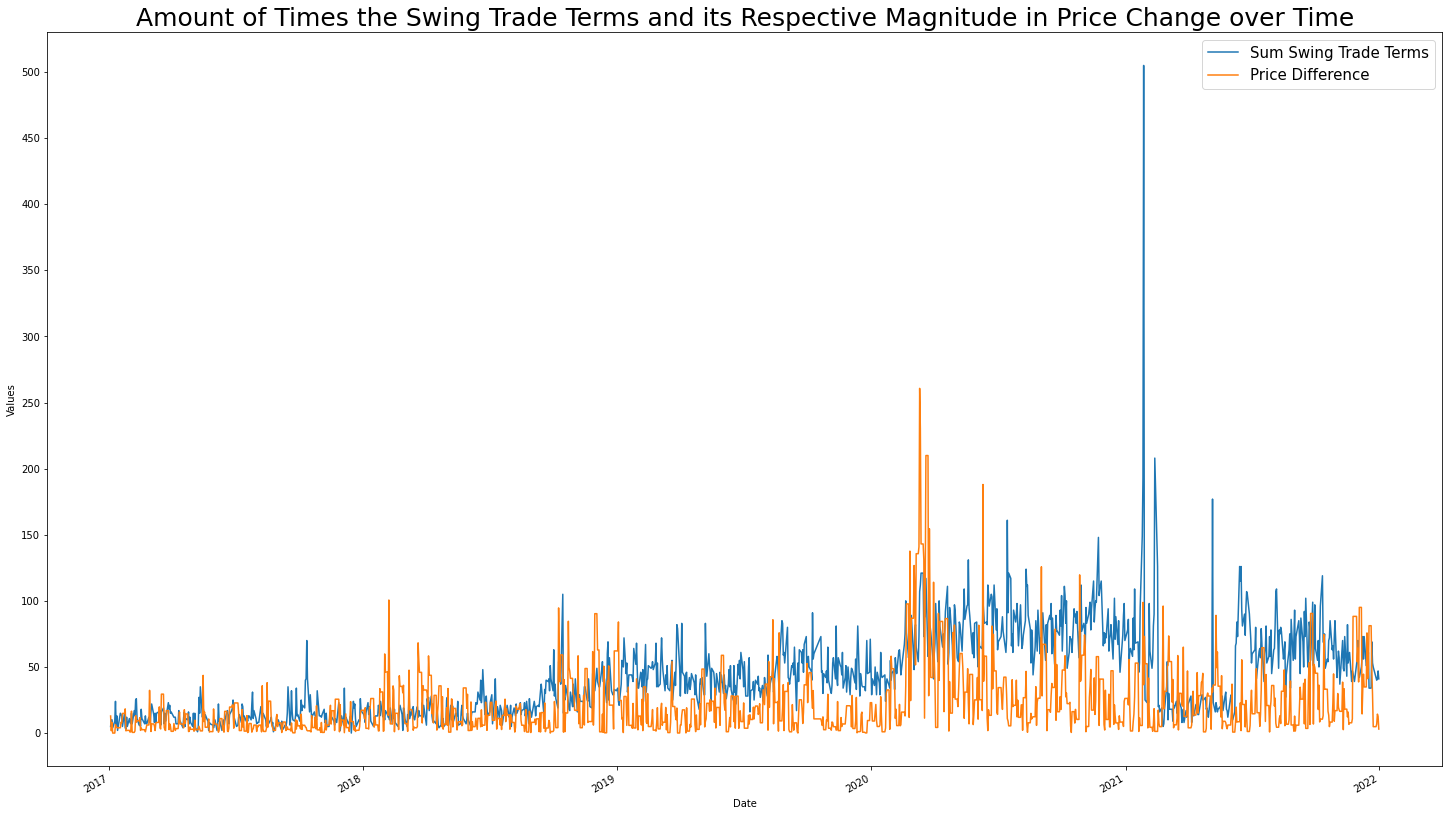

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(25, 15))

ax.plot(final_sum_df['date'], final_sum_df['sum_swing_trade_terms'], label='Sum Swing Trade Terms')
ax.plot(final_sum_df['date'], final_sum_df['absolute_price_diff'], label='Price Difference')
ax.set_xlabel('Date')
yticks = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
fig.autofmt_xdate()
ax.set_ylabel('Values')
ax.set_title('Amount of Times the Swing Trade Terms and its Respective Magnitude in Price Change over Time', fontsize=25)

ax.legend()
plt.legend(fontsize=15)
plt.show()

### Vichitra Kumar
##### Building a time series model to predict SPX index with Reddit users sentiment
##### -Index prediction with Reddit users sentiments
##### -Sentiment Analysis with Transfer learning(finBERT model) & Prediction with Prophet Time Series Model

In [0]:
# taking one year data for time series analysis
df4 = df.limit(360)
df4.show()

+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+
 _id| comments|created_utc| self_text|spx_index| title_list| date|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+
{6409ac8d88e3a86a...|[I pray you are r...| 2017-01-01|[, How do I short...| null|[I, too, posted s...|2017-01-01|
{6409ac8d88e3a86a...|[rekt, lol what a...| 2017-01-02|[[removed], , [re...| null|[What caused Nort...|2017-01-02|
{6409ac8d88e3a86a...|[Because the vich...| 2017-01-03|[, [deleted], I'm...| 2257.83|[Should I sell $D...|2017-01-03|
{6409ac8d88e3a86a...|[It's a pain to w...| 2017-01-04|[So I have 20, 9 ...| 2270.75|[XRX options, pls...|2017-01-04|
{6409ac8d88e3a86a...|[Buy EAT or NSP b...| 2017-01-05|[, [removed], All...| 2269.0|[$HRTX HTX-011 De...|2017-01-05|
{6409ac8d88e3a86a...|[I think that sta...| 2017-01-06|[Hi
I'm new here....| 2276.98|[New to r/wallstr...|2017-01-06|
{6409ac8d88e3a86a...|[Ah thanks!! You'...| 2017-01-07|[I bought some ma...| null|[$PANW....Going t...|2017-01-07|
{6409ac8d88e3a86a...|[That's insane. I...| 2017-01-08|[, , LULU will be...| null|[Throwback for ne...|2017-01-08|
{6409ac8d88e3a86a...|[Ichan owning FNM...| 2017-01-09|[, View full info...| 2268.9|[I think it's tim...|2017-01-09|
{6409ac8d88e3a86a...|[The strength in ...| 2017-01-10|[Here are the hig...| 2268.9|[High Momentum Sm...|2017-01-10|
{6409ac8d88e3a86a...|[Held UWTI in my ...| 2017-01-11|[, [removed], Any...| 2275.32|[Apparently insid...|2017-01-11|
{6409ac8d88e3a86a...|[Down 8% after ho...| 2017-01-12|[How do I monitor...| 2270.44|[TWS performance ...|2017-01-12|
{6409ac8d88e3a86a...|[What are the odd...| 2017-01-13|[[removed], HPQ i...| 2274.64|[Will FB &amp; CC...|2017-01-13|
{6409ac8d88e3a86a...|[100k on margin b...| 2017-01-14|[[removed], [dele...| null|[Palatin Technolo...|2017-01-14|
{6409ac8d88e3a86a...|[This is the pump...| 2017-01-15|[Let's say I buy ...| null|[Will this ETF st...|2017-01-15|
{6409ac8d88e3a86a...|[The Google pixel...| 2017-01-16|[, A few weeks ag...| null|[Using Scale Trad...|2017-01-16|
{6409ac8d88e3a86a...|[PUMP PUMP PUMP!!...| 2017-01-17|[It's about that ...| 2267.89|[Strong Chinese S...|2017-01-17|
{6409ac8d88e3a86a...|[Cutting loss is ...| 2017-01-18|[[deleted], I thi...| 2271.89|[Verizon has alre...|2017-01-18|
{6409ac8d88e3a86a...|[I’m so glad am i...| 2017-01-19|[Need to make mon...| 2263.69|[Which stocks doe...|2017-01-19|
{6409ac8d88e3a86a...|[Open an online d...| 2017-01-20|[[removed], , Buy...| 2271.31|[What the actual ...|2017-01-20|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+
only showing top 20 rows

In [0]:
def short_len(x):
    for i in range(len(x)):
        if len(x[i])>50:
            x[i] = x[i][:50]
        else:
            continue
    return x
short_len_udf = udf(short_len)

def process_array(x):
    return x[:50]
process_array_udf = udf(process_array)

def list_length(lst):
    return len(lst)
list_length_udf = udf(list_length)

def list_to_str(x):
    return ' '.join(x)
list_to_str_udf = udf(list_to_str)

In [0]:
df = df.withColumn('date', to_date(col('created_utc')))
df4 = df4.withColumn("concat_comm_st_list", concat("comments", "self_text", "title_list"))
df4 = df4.withColumn("concat_comm_st_list", short_len_udf(df4["concat_comm_st_list"]))
df4 = df4.withColumn("concat_comm_st_list", process_array_udf(df4["concat_comm_st_list"]))
#df4 = df4.withColumn("concat_comm_st_list", list_length_udf(df4["concat_comm_st_list"]))
#df4 = df4.withColumn("concat_comm_st_list", list_to_str_udf(df4["concat_comm_st_list"]))
df4.show()

+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+--------------------+
 _id| comments|created_utc| self_text|spx_index| title_list| date| concat_comm_st_list|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+--------------------+
{6409ac8d88e3a86a...|[I pray you are r...| 2017-01-01|[, How do I short...| null|[I, too, posted s...|2017-01-01|[I pray you are r...|
{6409ac8d88e3a86a...|[rekt, lol what a...| 2017-01-02|[[removed], , [re...| null|[What caused Nort...|2017-01-02|[rekt, lol what a...|
{6409ac8d88e3a86a...|[Because the vich...| 2017-01-03|[, [deleted], I'm...| 2257.83|[Should I sell $D...|2017-01-03|[Because the vich...|
{6409ac8d88e3a86a...|[It's a pain to w...| 2017-01-04|[So I have 20, 9 ...| 2270.75|[XRX options, pls...|2017-01-04|[It's a pain to w...|
{6409ac8d88e3a86a...|[Buy EAT or NSP b...| 2017-01-05|[, [removed], All...| 2269.0|[$HRTX HTX-011 De...|2017-01-05|[Buy EAT or NSP b...|
{6409ac8d88e3a86a...|[I think that sta...| 2017-01-06|[Hi
I'm new here....| 2276.98|[New to r/wallstr...|2017-01-06|[I think that sta...|
{6409ac8d88e3a86a...|[Ah thanks!! You'...| 2017-01-07|[I bought some ma...| null|[$PANW....Going t...|2017-01-07|[Ah thanks!! You'...|
{6409ac8d88e3a86a...|[That's insane. I...| 2017-01-08|[, , LULU will be...| null|[Throwback for ne...|2017-01-08|[That's insane. I...|
{6409ac8d88e3a86a...|[Ichan owning FNM...| 2017-01-09|[, View full info...| 2268.9|[I think it's tim...|2017-01-09|[Ichan owning FNM...|
{6409ac8d88e3a86a...|[The strength in ...| 2017-01-10|[Here are the hig...| 2268.9|[High Momentum Sm...|2017-01-10|[The strength in ...|
{6409ac8d88e3a86a...|[Held UWTI in my ...| 2017-01-11|[, [removed], Any...| 2275.32|[Apparently insid...|2017-01-11|[Held UWTI in my ...|
{6409ac8d88e3a86a...|[Down 8% after ho...| 2017-01-12|[How do I monitor...| 2270.44|[TWS performance ...|2017-01-12|[Down 8% after ho...|
{6409ac8d88e3a86a...|[What are the odd...| 2017-01-13|[[removed], HPQ i...| 2274.64|[Will FB &amp; CC...|2017-01-13|[What are the odd...|
{6409ac8d88e3a86a...|[100k on margin b...| 2017-01-14|[[removed], [dele...| null|[Palatin Technolo...|2017-01-14|[100k on margin b...|
{6409ac8d88e3a86a...|[This is the pump...| 2017-01-15|[Let's say I buy ...| null|[Will this ETF st...|2017-01-15|[This is the pump...|
{6409ac8d88e3a86a...|[The Google pixel...| 2017-01-16|[, A few weeks ag...| null|[Using Scale Trad...|2017-01-16|[The Google pixel...|
{6409ac8d88e3a86a...|[PUMP PUMP PUMP!!...| 2017-01-17|[It's about that ...| 2267.89|[Strong Chinese S...|2017-01-17|[PUMP PUMP PUMP!!...|
{6409ac8d88e3a86a...|[Cutting loss is ...| 2017-01-18|[[deleted], I thi...| 2271.89|[Verizon has alre...|2017-01-18|[Cutting loss is ...|
{6409ac8d88e3a86a...|[I’m so glad am i...| 2017-01-19|[Need to make mon...| 2263.69|[Which stocks doe...|2017-01-19|[I’m so glad am i...|
{6409ac8d88e3a86a...|[Open an online d...| 2017-01-20|[[removed], , Buy...| 2271.31|[What the actual ...|2017-01-20|[Open an online d...|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+--------------------+
only showing top 20 rows

In [0]:
model_name = "yiyanghkust/finbert-tone"
fin_tokenizer = AutoTokenizer.from_pretrained(model_name, padding=True, truncation=True, model_max_length=512)
#fin_tokenizer = fin_tokenizer.to('cuda')
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
#model = model.to('cuda').half()
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
nlp_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=fin_tokenizer)

In [0]:
def get_sentiment(sentence_list):
    tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
    sentiments = nlp_pipeline(sentence_list, **tokenizer_kwargs)
    daily_sentiment_dict = {'Positive': 0, 'Negative': 0, 'Neutral':0}
    pos_count = neg_count = neut_count = 1
    
    for each_dict in sentiments:
        score = each_dict['score']
        if each_dict['label'] == 'Positive':
            daily_sentiment_dict['Positive'] = daily_sentiment_dict['Positive'] + score
            pos_count += 1
        elif each_dict['label'] == 'Negative':
            daily_sentiment_dict['Negative'] = daily_sentiment_dict['Negative'] + score
            neg_count += 1
        else:
            daily_sentiment_dict['Neutral'] = daily_sentiment_dict['Neutral'] + score
            neut_count += 1
    
    daily_sentiment_dict['Positive'] = daily_sentiment_dict['Positive']/pos_count
    daily_sentiment_dict['Negative'] = daily_sentiment_dict['Negative']/neg_count
    daily_sentiment_dict['Neutral'] = daily_sentiment_dict['Neutral']/neut_count
    
    return daily_sentiment_dict

sentiment_udf = udf(get_sentiment)

In [0]:
df5 = df4.withColumn("daily_senti_col", sentiment_udf(df4['concat_comm_st_list']))

In [0]:
df5.show()

+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+--------------------+--------------------+
 _id| comments|created_utc| self_text|spx_index| title_list| date| concat_comm_st_list| daily_senti_col|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+--------------------+--------------------+
{6409ac8d88e3a86a...|[I pray you are r...| 2017-01-01|[, How do I short...| null|[I, too, posted s...|2017-01-01|[I pray you are r...|{Neutral=0.949661...|
{6409ac8d88e3a86a...|[rekt, lol what a...| 2017-01-02|[[removed], , [re...| null|[What caused Nort...|2017-01-02|[rekt, lol what a...|{Neutral=0.973161...|
{6409ac8d88e3a86a...|[Because the vich...| 2017-01-03|[, [deleted], I'm...| 2257.83|[Should I sell $D...|2017-01-03|[Because the vich...|{Neutral=0.941526...|
{6409ac8d88e3a86a...|[It's a pain to w...| 2017-01-04|[So I have 20, 9 ...| 2270.75|[XRX options, pls...|2017-01-04|[It's a pain to w...|{Neutral=0.964160...|
{6409ac8d88e3a86a...|[Buy EAT or NSP b...| 2017-01-05|[, [removed], All...| 2269.0|[$HRTX HTX-011 De...|2017-01-05|[Buy EAT or NSP b...|{Neutral=0.945298...|
{6409ac8d88e3a86a...|[I think that sta...| 2017-01-06|[Hi
I'm new here....| 2276.98|[New to r/wallstr...|2017-01-06|[I think that sta...|{Neutral=0.925154...|
{6409ac8d88e3a86a...|[Ah thanks!! You'...| 2017-01-07|[I bought some ma...| null|[$PANW....Going t...|2017-01-07|[Ah thanks!! You'...|{Neutral=0.940004...|
{6409ac8d88e3a86a...|[That's insane. I...| 2017-01-08|[, , LULU will be...| null|[Throwback for ne...|2017-01-08|[That's insane. I...|{Neutral=0.957965...|
{6409ac8d88e3a86a...|[Ichan owning FNM...| 2017-01-09|[, View full info...| 2268.9|[I think it's tim...|2017-01-09|[Ichan owning FNM...|{Neutral=0.963731...|
{6409ac8d88e3a86a...|[The strength in ...| 2017-01-10|[Here are the hig...| 2268.9|[High Momentum Sm...|2017-01-10|[The strength in ...|{Neutral=0.964976...|
{6409ac8d88e3a86a...|[Held UWTI in my ...| 2017-01-11|[, [removed], Any...| 2275.32|[Apparently insid...|2017-01-11|[Held UWTI in my ...|{Neutral=0.949347...|
{6409ac8d88e3a86a...|[Down 8% after ho...| 2017-01-12|[How do I monitor...| 2270.44|[TWS performance ...|2017-01-12|[Down 8% after ho...|{Neutral=0.949516...|
{6409ac8d88e3a86a...|[What are the odd...| 2017-01-13|[[removed], HPQ i...| 2274.64|[Will FB &amp; CC...|2017-01-13|[What are the odd...|{Neutral=0.930697...|
{6409ac8d88e3a86a...|[100k on margin b...| 2017-01-14|[[removed], [dele...| null|[Palatin Technolo...|2017-01-14|[100k on margin b...|{Neutral=0.957123...|
{6409ac8d88e3a86a...|[This is the pump...| 2017-01-15|[Let's say I buy ...| null|[Will this ETF st...|2017-01-15|[This is the pump...|{Neutral=0.936670...|
{6409ac8d88e3a86a...|[The Google pixel...| 2017-01-16|[, A few weeks ag...| null|[Using Scale Trad...|2017-01-16|[The Google pixel...|{Neutral=0.940709...|
{6409ac8d88e3a86a...|[PUMP PUMP PUMP!!...| 2017-01-17|[It's about that ...| 2267.89|[Strong Chinese S...|2017-01-17|[PUMP PUMP PUMP!!...|{Neutral=0.953294...|
{6409ac8d88e3a86a...|[Cutting loss is ...| 2017-01-18|[[deleted], I thi...| 2271.89|[Verizon has alre...|2017-01-18|[Cutting loss is ...|{Neutral=0.930121...|
{6409ac8d88e3a86a...|[I’m so glad am i...| 2017-01-19|[Need to make mon...| 2263.69|[Which stocks doe...|2017-01-19|[I’m so glad am i...|{Neutral=0.945912...|
{6409ac8d88e3a86a...|[Open an online d...| 2017-01-20|[[removed], , Buy...| 2271.31|[What the actual ...|2017-01-20|[Open an online d...|{Neutral=0.959021...|
+--------------------+--------------------+-----------+--------------------+---------+--------------------+----------+--------------------+--------------------+
only showing top 20 rows

In [0]:
sentiment_df = df5.select("spx_index", "daily_senti_col", "date")

positive_udf = udf(lambda x: x['Positive'])
sentiment_df = sentiment_df.withColumn("Positive", positive_udf(sentiment_df['daily_senti_col']))

negative_udf = udf(lambda x: x['Negative'])
sentiment_df = sentiment_df.withColumn("Negative", negative_udf(sentiment_df['daily_senti_col']))

neutral_udf = udf(lambda x: x['Neutral'])
sentiment_df = sentiment_df.withColumn("Neutral", neutral_udf(sentiment_df['daily_senti_col']))

sentiment_df.show()


+---------+--------------------+----------+------------------+------------------+------------------+
spx_index| daily_senti_col| date| Positive| Negative| Neutral|
+---------+--------------------+----------+------------------+------------------+------------------+
 null|{Neutral=0.949661...|2017-01-01|0.8454770048459371|0.5618525147438049|0.9496610847915091|
 null|{Neutral=0.973161...|2017-01-02|0.6606477349996567| 0.687109899520874|0.9731612747365778|
 2257.83|{Neutral=0.941526...|2017-01-03|0.5414608418941498|0.6729931950569152|0.9415266717022116|
 2270.75|{Neutral=0.964160...|2017-01-04|0.7448371052742004| 0.695983624458313|0.9641604453325272|
 2269.0|{Neutral=0.945298...|2017-01-05|0.7127490520477295|0.7170402308305105|0.9452985439981733|
 2276.98|{Neutral=0.925154...|2017-01-06|0.4938046932220459|0.5849286317825317|0.9251544326543808|
 null|{Neutral=0.940004...|2017-01-07|0.7996133327484131|0.5448485414187113|0.9400047487682767|
 null|{Neutral=0.957965...|2017-01-08|0.8402343988418579|0.7140639543533325| 0.957965387403965|
 2268.9|{Neutral=0.963731...|2017-01-09| 0.749358206987381|0.7030084878206253| 0.963731058438619|
 2268.9|{Neutral=0.964976...|2017-01-10| 0.907152842391621|0.6038956046104431|0.9649768938889375|
 2275.32|{Neutral=0.949347...|2017-01-11|0.7499786615371704|0.7931569814682007|0.9493470150370931|
 2270.44|{Neutral=0.949516...|2017-01-12|0.8345843298094613|0.6280416250228882|0.9495160565143679|
 2274.64|{Neutral=0.930697...|2017-01-13|0.6422592600186666| 0.633813738822937|0.9306975996240656|
 null|{Neutral=0.957123...|2017-01-14|0.8303692738215128| 0.647039145231247|0.9571238026022911|
 null|{Neutral=0.936670...|2017-01-15|0.8534268438816071|0.6988815516233444|0.9366702960758675|
 null|{Neutral=0.940709...|2017-01-16|0.8690497597058614|0.6456943353017172| 0.94070965051651|
 2267.89|{Neutral=0.953294...|2017-01-17|0.6273968815803528|0.7517934242884318|0.9532946144992654|
 2271.89|{Neutral=0.930121...|2017-01-18|0.7947936177253723|0.7263764909335545|0.9301215482921135|
 2263.69|{Neutral=0.945912...|2017-01-19|0.4978662431240082|0.8030059238274893|0.9459121253755357|
 2271.31|{Neutral=0.959021...|2017-01-20|0.7577668329079946|0.6654762625694275|0.9590214626355604|
+---------+--------------------+----------+------------------+------------------+------------------+
only showing top 20 rows

In [0]:
sentiment_df = sentiment_df.withColumnRenamed("spx_index", "y").withColumnRenamed("date", "ds").drop("daily_senti_col")
sentiment_df.show()

+-------+----------+------------------+------------------+------------------+
 y| ds| Positive| Negative| Neutral|
+-------+----------+------------------+------------------+------------------+
 null|2017-01-01|0.8454770048459371|0.5618525147438049|0.9496610847915091|
 null|2017-01-02|0.6606477349996567| 0.687109899520874|0.9731612747365778|
2257.83|2017-01-03|0.5414608418941498|0.6729931950569152|0.9415266717022116|
2270.75|2017-01-04|0.7448371052742004| 0.695983624458313|0.9641604453325272|
 2269.0|2017-01-05|0.7127490520477295|0.7170402308305105|0.9452985439981733|
2276.98|2017-01-06|0.4938046932220459|0.5849286317825317|0.9251544326543808|
 null|2017-01-07|0.7996133327484131|0.5448485414187113|0.9400047487682767|
 null|2017-01-08|0.8402343988418579|0.7140639543533325| 0.957965387403965|
 2268.9|2017-01-09| 0.749358206987381|0.7030084878206253| 0.963731058438619|
 2268.9|2017-01-10| 0.907152842391621|0.6038956046104431|0.9649768938889375|
2275.32|2017-01-11|0.7499786615371704|0.7931569814682007|0.9493470150370931|
2270.44|2017-01-12|0.8345843298094613|0.6280416250228882|0.9495160565143679|
2274.64|2017-01-13|0.6422592600186666| 0.633813738822937|0.9306975996240656|
 null|2017-01-14|0.8303692738215128| 0.647039145231247|0.9571238026022911|
 null|2017-01-15|0.8534268438816071|0.6988815516233444|0.9366702960758675|
 null|2017-01-16|0.8690497597058614|0.6456943353017172| 0.94070965051651|
2267.89|2017-01-17|0.6273968815803528|0.7517934242884318|0.9532946144992654|
2271.89|2017-01-18|0.7947936177253723|0.7263764909335545|0.9301215482921135|
2263.69|2017-01-19|0.4978662431240082|0.8030059238274893|0.9459121253755357|
2271.31|2017-01-20|0.7577668329079946|0.6654762625694275|0.9590214626355604|
+-------+----------+------------------+------------------+------------------+
only showing top 20 rows

In [0]:
# Databricks doesn't have support for Prophet model. Hence, converting to Pandas dataframe
train_df = sentiment_df.toPandas()
train_df.fillna(method='bfill')

Out[190]:

,y,ds,Positive,Negative,Neutral
0,2271.89,2017-01-18,0.7947936177253723,0.7263764909335545,0.9301215482921135
1,2263.69,2017-01-19,0.4978662431240082,0.8030059238274893,0.9459121253755357
2,2271.31,2017-01-20,0.7577668329079946,0.6654762625694275,0.9590214626355604
3,2265.20,2017-01-21,0.8560139451708112,0.8001847962538401,0.9486745566129684
4,2265.20,2017-01-22,0.8476679921150208,0.6900157034397125,0.9450553132266533
...,...,...,...,...,...
95,2374.15,2017-04-23,0.7257526516914368,0.7873552665114403,0.9510275064370571
96,2374.15,2017-04-24,0.6912505507469178,0.8266482055187225,0.9564162611961364
97,2388.61,2017-04-25,0.8300217092037201,0.7163389027118683,0.954577486182368
98,2387.45,2017-04-26,0.5282689929008484,0.710885192666735,0.9461294967074727


In [0]:
model = Prophet(changepoint_prior_scale=0.01, seasonality_mode='additive',
                yearly_seasonality=False, weekly_seasonality=True,
                daily_seasonality=True, holidays=None,
                seasonality_prior_scale=10.0,
                changepoint_range=0.95, interval_width=0.8,
                holidays_prior_scale=10.0,
                uncertainty_samples=1000)

model.add_regressor('Positive', standardize=False)
model.add_regressor('Negative', standardize=False)
model.add_regressor('Neutral', standardize=False)


In [0]:
# predicting for next 15 days
test_size = 15
df_train, df_test = df.iloc[:(df.shape[0]-test_size)], df.iloc[-test_size:]
df_test.cache()
forecast = model.predict(df_test)
y_true = df_test['y']
y_preds = forecast['yhat']
df_test.unpersist()
mae = mean_absolute_error(y_true, y_preds)
print("Mean Absolute Error:", mae)